# Sentiment experiments — preprocessing and model comparison
This notebook will contain the ML engineering pipeline: preprocessing the IMDB-style `MOVIES.csv`, `IDMB_DATASET_MOVIE_REVIEW.csv`  dataset, extracting the simple lexicon-based features used in the educational notebook (`bias`, `pos_count`, `neg_count`), training/tuning Logistic Regression, Multinomial Naive Bayes and Decision Tree classifiers, evaluating them, and visualizing results.

##### We first test the effect of movie overviews on user sentiment to see if it has any effects ####
##### Then we proceed to use movie review to predict sentiments in such a way that we can gain an overall view on the rating of the movies simply based on the reviews.

In [53]:
# Imports and helpers for experiments
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from utils import preprocess_text, build_frequency_dict, extract_features

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

# Small from-scratch helpers (same idea as in `log_reg.ipynb`) for demonstration
import warnings
warnings.filterwarnings('ignore')

def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def initialize_parameters(n=3):
    return np.random.randn(n, 1) * 0.1

def calculate_cost(X, z, Y, theta):
    m = X.shape[0]
    h = sigmoid(z)
    eps = 1e-15
    h = np.clip(h, eps, 1 - eps)
    cost = -1.0/m * (np.dot(Y.T, np.log(h)) + np.dot((1 - Y).T, np.log(1 - h)))
    return float(np.squeeze(cost))

def gradient_descent(X, Y, num_iters=1000, learning_rate=0.001):
    cost_history = []
    m, n = X.shape
    Y = Y.reshape(-1, 1)
    theta = initialize_parameters(n)
    for i in range(num_iters):
        z = X @ theta
        h = sigmoid(z)
        cost = calculate_cost(X, z, Y, theta)
        cost_history.append(cost)
        d_theta = (1.0 / m) * (X.T @ (h - Y))
        theta = theta - learning_rate * d_theta
    return cost_history, np.array(theta, dtype=float)

In [54]:
movies = pd.read_csv("IMDB_Dataset.csv")
print(len(movies))
movies.head()

50000


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [55]:
# let look at a review
movies['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [56]:
movies = movies[['review', 'sentiment']].dropna()
reviews = movies['review'].tolist()
sentiments = movies['sentiment'].tolist()

# Preprocess text
reviews = [preprocess_text(r) for r in reviews]
sentiments = [1 if s == 'positive' else 0 for s in sentiments]
for r, s in zip(reviews[:5], sentiments[:5]):
    print(f"Review: {r}\nSentiment: {s}\n")
sentiments = np.array(sentiments)
sentiments.shape


Review: one review mention watch oz episod hook right exactli happen br br first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word br br call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away br br would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get t

(50000,)

In [57]:
df_train, df_test, y_train, y_test = train_test_split(
    pd.DataFrame(reviews), sentiments, test_size=0.4, stratify=sentiments, random_state=42
)
print("Train size:", df_train.shape[0], "test_size:", df_test.shape[0])
df_train = df_train[0].tolist()
df_test = df_test[0].tolist()
frequency_dict = build_frequency_dict(df_train, y_train)
X_train = np.zeros((len(df_train), 3))
for i, txt in enumerate(df_train):
    X_train[i, :] = extract_features(txt, frequency_dict)
    
X_test = np.zeros((len(df_test), 3))
for i, txt in enumerate(df_test):
    X_test[i, :] = extract_features(txt, frequency_dict)
    
print('Feature sample (train):')
print(X_train[:5])
    


Train size: 30000 test_size: 20000
Feature sample (train):
[[1.000000e+00 3.142600e+05 3.525260e+05]
 [1.000000e+00 7.930280e+05 8.307790e+05]
 [1.000000e+00 1.806970e+05 1.929130e+05]
 [1.000000e+00 1.680877e+06 1.765211e+06]
 [1.000000e+00 1.552090e+05 1.819210e+05]]


In [58]:
models = {
    'LogisticRegression': {
        'estimator': LogisticRegression(solver='liblinear', max_iter=1000, fit_intercept=True),
        'params': {'C': [0.01, 0.1, 1, 10]}
    },
    'MultinomialNB': {
        'estimator': MultinomialNB(),
        'params': {'alpha': [0.1, 0.5, 1.0]}
    },
    'DecisionTree': {
        'estimator': DecisionTreeClassifier(random_state=42),
        'params': {'max_depth': [3, 5, 10, None], 'min_samples_leaf': [1, 2, 5]}
    }
}
# Recreate raw-count feature matrices for  MultinomialNB
X_train_counts = np.zeros((len(df_train), 3))
for i, txt in enumerate(df_train):
    X_train_counts[i, :] = extract_features(txt, frequency_dict)
X_test_counts = np.zeros((len(df_test), 3))
for i, txt in enumerate(df_test):
    X_test_counts[i, :] = extract_features(txt, frequency_dict)
# exclude bias
X_train_counts_sc = X_train_counts[:, 1:]
X_test_counts_sc = X_test_counts[:, 1:] 

# sklearn can already handle the bias term internally, so we exclude it from features


results = []
for name, md in models.items():
    print(f"Tuning {name}...")
    # choose dataset appropriately
    X_fit = X_train_counts_sc
    X_eval = X_test_counts_sc

    grid = GridSearchCV(md['estimator'], md['params'], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_fit, y_train)
    best = grid.best_estimator_
    y_pred = best.predict(X_eval)
    y_proba = best.predict_proba(X_eval)[:,1] if hasattr(best, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    print(f"{name} best params: {grid.best_params_} | f1: {f1:.4f} | acc: {acc:.4f}")

    results.append({'model': name, 'best_params': grid.best_params_, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc})
    joblib.dump(best, f"{name}_best.joblib")

Tuning LogisticRegression...
LogisticRegression best params: {'C': 0.01} | f1: 0.6834 | acc: 0.6856
Tuning MultinomialNB...
MultinomialNB best params: {'alpha': 0.1} | f1: 0.6881 | acc: 0.6856
Tuning DecisionTree...
DecisionTree best params: {'max_depth': None, 'min_samples_leaf': 5} | f1: 0.6098 | acc: 0.6179


In [59]:
pd.DataFrame(results).sort_values('f1', ascending=False)

,model,best_params,accuracy,precision,recall,f1,roc_auc
1,MultinomialNB,{'alpha': 0.1},0.68565,0.682780,0.6935,0.688098,0.718812
0,LogisticRegression,{'C': 0.01},0.68565,0.688267,0.6787,0.683450,0.751171
2,DecisionTree,"{'max_depth': None, 'min_samples_leaf': 5}",0.61795,0.623108,0.5970,0.609775,0.661494



LogisticRegression classification metrics:
Accuracy: 0.6856 | Precision: 0.6883 | Recall: 0.6787 | F1: 0.6834 | ROC-AUC: 0.7512


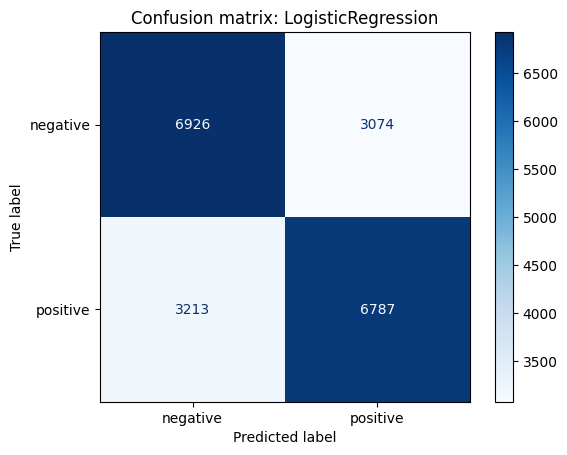

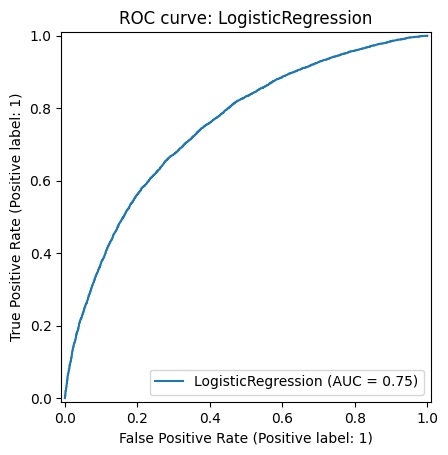


MultinomialNB classification metrics:
Accuracy: 0.6856 | Precision: 0.6828 | Recall: 0.6935 | F1: 0.6881 | ROC-AUC: 0.7188


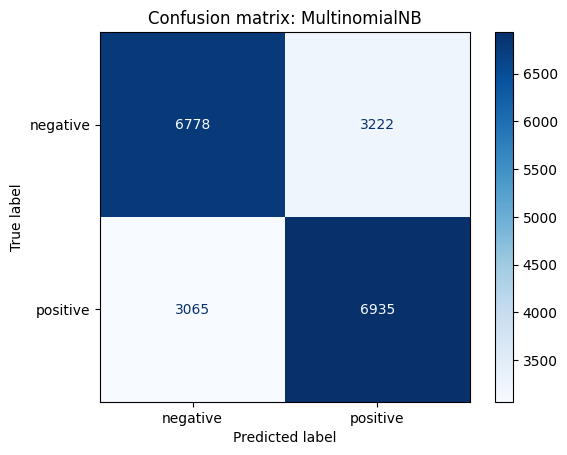

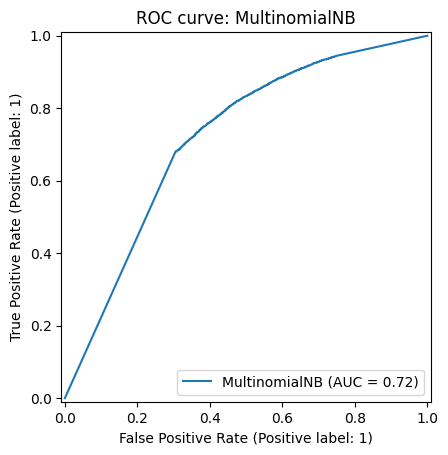


DecisionTree classification metrics:
Accuracy: 0.6179 | Precision: 0.6231 | Recall: 0.5970 | F1: 0.6098 | ROC-AUC: 0.6615


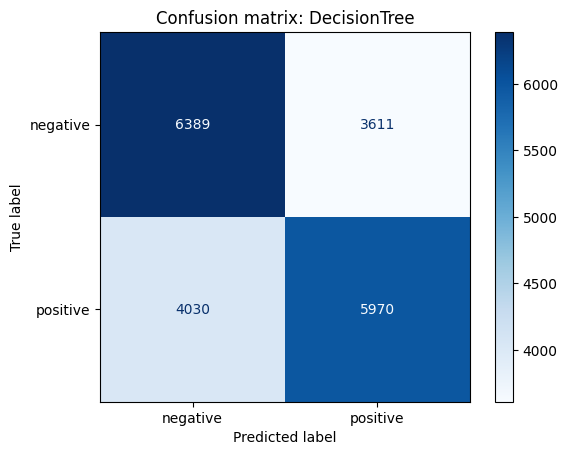

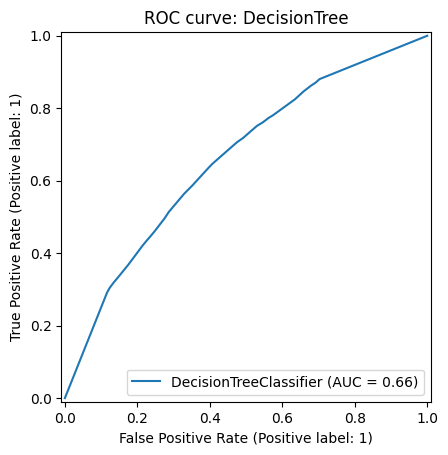

In [60]:
for r in results:
    name = r['model']
    model = joblib.load(f"{name}_best.joblib")
    y_pred = model.predict(X_test[:,1:])
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name} classification metrics:")
    print(f"Accuracy: {r['accuracy']:.4f} | Precision: {r['precision']:.4f} | Recall: {r['recall']:.4f} | F1: {r['f1']:.4f} | ROC-AUC: {r['roc_auc']:.4f}")
    disp = ConfusionMatrixDisplay(cm, display_labels=['negative','positive'])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion matrix: {name}")
    plt.show()
    if hasattr(model, 'predict_proba'):
        RocCurveDisplay.from_estimator(model, X_test[:,1:], y_test)
        plt.title(f"ROC curve: {name}")
        plt.show()

Weve Decided that Logistic Regression and Naive Bayes are the best for this dataset, now we want to create a pipeline where we use logistic regression to split the classes and determine if a review is positive or negative from raw text

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


class FeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Custom transformer to extract sentiment features from raw text.
    Works within sklearn Pipeline to handle raw text → features conversion.
    """
    def __init__(self, frequency_dict):
        self.frequency_dict = frequency_dict

    def fit(self, X, y=None):
        """No fitting needed - frequency dict is pre-built."""
        return self

    def transform(self, X):
        """
        Transform raw text reviews into feature vectors.
        
        Args:
            X: Array-like of raw text strings
            
        Returns:
            Feature matrix (n_samples, 2) with [pos_count, neg_count]
            excluding the bias term
        """
        X = np.atleast_1d(X)
        n_samples = len(X)
        X_features = np.zeros((n_samples, 3))
        
        # Single pass: preprocess and extract features (no redundant preprocessing)
        for i, txt in enumerate(X):
            X_features[i, :] = extract_features(txt, self.frequency_dict)
        
        return X_features[:, 1:]  # Return [pos_count, neg_count] excluding bias


# Create pipeline: raw text → features → prediction
best_model = joblib.load("LogisticRegression_best.joblib")
pipeline_model = Pipeline([
    ('feature_extractor', FeatureExtractor(frequency_dict)),
    ('classifier', best_model)
])

print("✓ Pipeline created successfully!")
print(f"Pipeline steps: {[name for name, _ in pipeline_model.steps]}")


✓ Pipeline created successfully!
Pipeline steps: ['feature_extractor', 'classifier']


In [62]:
# Test the pipeline with sample user input
print("=" * 70)
print("PIPELINE TEST: User input → Sentiment prediction")
print("=" * 70)

# Test cases with different sentiments
test_reviews = [
    "This movie is absolutely amazing and I loved every second of it!",
    "Terrible film, waste of time and money. Horrible acting.",
    "It was okay, nothing special but not bad either.",
    "Outstanding performance! Best movie I've ever seen!",
    "Awful script, boring plot, fell asleep halfway through."
]

print("\nTest predictions:\n")
for review in test_reviews:
    # Pipeline automatically: preprocess → extract features → predict
    prediction = pipeline_model.predict([review])[0]
    confidence = pipeline_model.predict_proba([review])[0]
    
    sentiment = "POSITIVE" if prediction == 1 else "NEGATIVE"
    print(f"Review: {review[:60]}...")
    print(f"Prediction: {sentiment} (confidence: {max(confidence):.2%})\n")

print("=" * 70)


PIPELINE TEST: User input → Sentiment prediction

Test predictions:

Review: This movie is absolutely amazing and I loved every second of...
Prediction: NEGATIVE (confidence: 51.51%)

Review: Terrible film, waste of time and money. Horrible acting....
Prediction: NEGATIVE (confidence: 51.05%)

Review: It was okay, nothing special but not bad either....
Prediction: NEGATIVE (confidence: 58.15%)

Review: Outstanding performance! Best movie I've ever seen!...
Prediction: NEGATIVE (confidence: 51.28%)

Review: Awful script, boring plot, fell asleep halfway through....
Prediction: NEGATIVE (confidence: 56.01%)



In [63]:
# Interactive prediction function for user input
def predict_sentiment(user_review):
    """
    Predict sentiment of a user-provided review using the trained pipeline.
    
    Args:
        user_review (str): Raw review text from user
        
    Returns:
        tuple: (prediction, confidence_dict)
            - prediction: 'POSITIVE' or 'NEGATIVE'
            - confidence_dict: {'positive': float, 'negative': float}
    """
    # Pipeline handles preprocessing + feature extraction + prediction
    pred_label = pipeline_model.predict([user_review])[0]
    pred_proba = pipeline_model.predict_proba([user_review])[0]
    
    sentiment = "POSITIVE" if pred_label == 1 else "NEGATIVE"
    confidence = {
        "negative": pred_proba[0] * 100,
        "positive": pred_proba[1] * 100
    }
    
    return sentiment, confidence


# Example usage
print("\n" + "=" * 70)
print("EXAMPLE: Using predict_sentiment() function")
print("=" * 70)

user_input = "This movie was fantastic! I really enjoyed watching it."
sentiment, confidence = predict_sentiment(user_input)

print(f"\nReview: {user_input}")
print(f"\nResult:")
print(f"  Sentiment: {sentiment}")
print(f"  Confidence: Positive {confidence['positive']:.1f}% | Negative {confidence['negative']:.1f}%")



EXAMPLE: Using predict_sentiment() function

Review: This movie was fantastic! I really enjoyed watching it.

Result:
  Sentiment: NEGATIVE
  Confidence: Positive 44.9% | Negative 55.1%


In [64]:
# ============================================================================
# FINAL PIPELINE: End-to-End Sentiment Prediction from Raw Text
# ============================================================================
print("\n" + "="*80)
print("SENTIMENT ANALYSIS PIPELINE - LIVE PREDICTIONS")
print("="*80)

# Define a batch prediction function
def batch_predict(reviews):
    """Predict sentiment for multiple reviews at once."""
    predictions = pipeline_model.predict(reviews)
    probabilities = pipeline_model.predict_proba(reviews)
    
    results = []
    for i, review in enumerate(reviews):
        sentiment = "positive" if predictions[i] == 1 else "negative"
        confidence = max(probabilities[i]) * 100
        results.append({
            'review': review,
            'sentiment': sentiment,
            'confidence': confidence,
            'pos_prob': probabilities[i][1] * 100,
            'neg_prob': probabilities[i][0] * 100
        })
    return results

# Test the pipeline with various reviews
test_reviews = [
    "This movie is absolutely amazing! I loved every minute of it!",
    "Terrible film, waste of money. Couldn't finish watching it.",
    "It was okay, nothing special.",
    "Best movie ever! Outstanding acting and brilliant story!",
    "Horrible, boring, put me to sleep. Very disappointed.",
    "Pretty good, entertaining and well made.",
    "I hated this movie, worst ever!",
    "Wonderful! Exceeded my expectations completely!"
]

# Batch predict
results = batch_predict(test_reviews)

# Display results in a nice format
for idx, result in enumerate(results, 1):
    print(f"\n[{idx}] Review: {result['review']}")
    print(f"    Prediction: {result['sentiment']}")
    print(f"    Confidence: {result['confidence']:.1f}%")
    print(f"    Breakdown: Positive={result['pos_prob']:.1f}% | Negative={result['neg_prob']:.1f}%")

print("\n" + "="*80)



SENTIMENT ANALYSIS PIPELINE - LIVE PREDICTIONS

[1] Review: This movie is absolutely amazing! I loved every minute of it!
    Prediction: negative
    Confidence: 52.9%
    Breakdown: Positive=47.1% | Negative=52.9%

[2] Review: Terrible film, waste of money. Couldn't finish watching it.
    Prediction: negative
    Confidence: 50.4%
    Breakdown: Positive=49.6% | Negative=50.4%

[3] Review: It was okay, nothing special.
    Prediction: negative
    Confidence: 52.1%
    Breakdown: Positive=47.9% | Negative=52.1%

[4] Review: Best movie ever! Outstanding acting and brilliant story!
    Prediction: negative
    Confidence: 52.4%
    Breakdown: Positive=47.6% | Negative=52.4%

[5] Review: Horrible, boring, put me to sleep. Very disappointed.
    Prediction: negative
    Confidence: 53.3%
    Breakdown: Positive=46.7% | Negative=53.3%

[6] Review: Pretty good, entertaining and well made.
    Prediction: positive
    Confidence: 52.4%
    Breakdown: Positive=52.4% | Negative=47.6%

[7] R

From-scratch Logistic regression accuracy: 0.5697


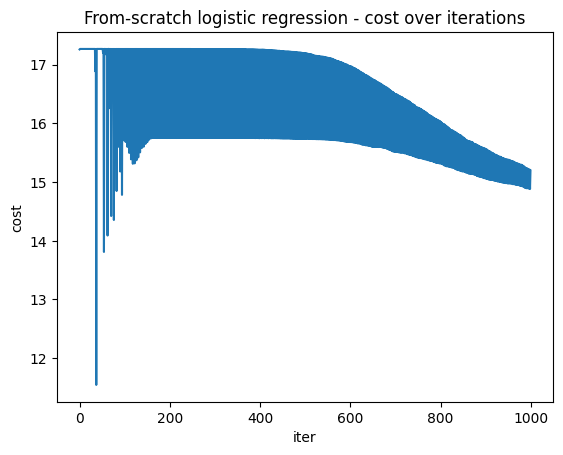

In [65]:
# Educational: from-scratch logistic regression on these features (bias included)
costs, theta = gradient_descent( X_train_counts, y_train, num_iters=1000, learning_rate=0.5)
probs = sigmoid(np.dot(X_test_counts, theta)).flatten()
y_pred = (probs >= 0.5).astype(int)
print('From-scratch Logistic regression accuracy:', np.mean(y_pred == y_test))
plt.plot(costs)
plt.title('From-scratch logistic regression - cost over iterations')
plt.xlabel('iter')
plt.ylabel('cost')
plt.show()

In [66]:
# ============================================================================
# DIAGNOSIS: Debug why pipeline predicts everything as negative
# ============================================================================

print("DEBUG: Checking feature extraction consistency\n")

# Test review
test_review = "This movie is amazing and I loved it!"

# Path 1: How training data was processed (already preprocessed)
print(f"Original review: {test_review}")
preprocessed = preprocess_text(test_review)
print(f"After preprocess_text(): {preprocessed}")

# Path 2: Extract features (preprocesses internally)
features = extract_features(test_review, frequency_dict)
print(f"\nFeatures extracted: {features}")
print(f"Features without bias: {features[1:]}")

# Path 3: Check actual frequency dict
print(f"\nFrequency dict sample (first 20 items):")
for i, (key, val) in enumerate(list(frequency_dict.items())[:20]):
    print(f"  {key}: {val}")

# Path 4: Manual check - what words are being found?
words = preprocess_text(test_review).split()
print(f"\nWords extracted from test review: {words}")
print(f"Checking which words are in frequency_dict:")
for word in words:
    pos_count = frequency_dict.get((word, 1), 0)
    neg_count = frequency_dict.get((word, 0), 0)
    print(f"  '{word}': pos={pos_count}, neg={neg_count}")

# The issue: frequency_dict was built from df_train which was ALREADY PREPROCESSED
# But df_train came from reviews which were preprocessed ONCE
# So words in frequency_dict are the stemmed versions
print(f"\nISSUE DIAGNOSIS:")
print(f"  - Training data (df_train): Already preprocessed text")
print(f"  - Frequency dict: Built from df_train words")
print(f"  - Pipeline input: Raw text → preprocesses → extracts features")
print(f"  - This should match IF preprocessing is consistent!")


DEBUG: Checking feature extraction consistency

Original review: This movie is amazing and I loved it!
After preprocess_text(): movi amaz love

Features extracted: [    1 35640 39042]
Features without bias: [35640 39042]

Frequency dict sample (first 20 items):
  ('look', np.int64(0)): 7196
  ('cool', np.int64(0)): 660
  ('movi', np.int64(0)): 35067
  ('sleev', np.int64(0)): 40
  ('five', np.int64(0)): 602
  ('minut', np.int64(0)): 3147
  ('sure', np.int64(0)): 1972
  ('homosexu', np.int64(0)): 108
  ('documentari', np.int64(0)): 479
  ('west', np.int64(0)): 205
  ('side', np.int64(0)): 800
  ('stori', np.int64(0)): 6676
  ('without', np.int64(0)): 1903
  ('femal', np.int64(0)): 676
  ('interest', np.int64(0)): 2920
  ('film', np.int64(0)): 27118
  ('qualiti', np.int64(0)): 1024
  ('poor', np.int64(0)): 1838
  ('hardli', np.int64(0)): 410
  ('enough', np.int64(0)): 2465

Words extracted from test review: ['movi', 'amaz', 'love']
Checking which words are in frequency_dict:
  'movi': pos

In [67]:
# ============================================================================
# DIAGNOSIS: Why is the pipeline predicting everything as negative?
# ============================================================================

print("DEBUG: Model Analysis\n")
print("="*80)

# Check 1: What did the model actually learn?
print("\n1. MODEL COEFFICIENTS (what it learned):")
model = joblib.load("LogisticRegression_best.joblib")
print(f"   Intercept: {model.intercept_[0]:.4f}")
print(f"   Coefficients: {model.coef_[0]}")
print(f"   Feature 0 (pos_count): {model.coef_[0][0]:.4f}")
print(f"   Feature 1 (neg_count): {model.coef_[0][1]:.4f}")

# Check 2: Test data prediction distribution
print("\n2. MODEL TEST SET PREDICTIONS:")
y_pred_test = model.predict(X_test_counts_sc)
y_proba_test = model.predict_proba(X_test_counts_sc)
print(f"   Actual positive: {(y_test == 1).sum()}")
print(f"   Actual negative: {(y_test == 0).sum()}")
print(f"   Predicted positive: {(y_pred_test == 1).sum()}")
print(f"   Predicted negative: {(y_pred_test == 0).sum()}")
print(f"   Test accuracy: {(y_pred_test == y_test).mean():.3f}")

# Check 3: Feature statistics
print("\n3. FEATURE STATISTICS (raw counts, no normalization):")
print(f"   Positive count - Mean: {X_test_counts_sc[:, 0].mean():.2f}, Std: {X_test_counts_sc[:, 0].std():.2f}")
print(f"   Negative count - Mean: {X_test_counts_sc[:, 1].mean():.2f}, Std: {X_test_counts_sc[:, 1].std():.2f}")

# Check 4: What features does a test review actually get?
test_review = "This movie is amazing and I loved it!"
test_features = extract_features(test_review, frequency_dict)[1:]  # Remove bias
test_pred = model.predict([test_features])[0]
test_proba = model.predict_proba([test_features])[0]

print(f"\n4. SAMPLE TEST REVIEW:")
print(f"   Review: '{test_review}'")
print(f"   Features [pos_count, neg_count]: {test_features}")
print(f"   Model prediction: {'POSITIVE' if test_pred == 1 else 'NEGATIVE'}")
print(f"   Probabilities: Pos={test_proba[1]:.3f}, Neg={test_proba[0]:.3f}")

# Manual calculation
logit = model.intercept_[0] + np.dot(model.coef_[0], test_features)
prob_positive = 1 / (1 + np.exp(-logit))
print(f"   Manual logit calculation: {logit:.4f} → Prob(positive)={prob_positive:.3f}")

print("\n" + "="*80)


DEBUG: Model Analysis


1. MODEL COEFFICIENTS (what it learned):
   Intercept: 0.0000
   Coefficients: [ 3.54073137e-05 -3.36335698e-05]
   Feature 0 (pos_count): 0.0000
   Feature 1 (neg_count): -0.0000

2. MODEL TEST SET PREDICTIONS:
   Actual positive: 10000
   Actual negative: 10000
   Predicted positive: 9861
   Predicted negative: 10139
   Test accuracy: 0.686

3. FEATURE STATISTICS (raw counts, no normalization):
   Positive count - Mean: 564962.40, Std: 478497.76
   Negative count - Mean: 596649.36, Std: 505270.54

4. SAMPLE TEST REVIEW:
   Review: 'This movie is amazing and I loved it!'
   Features [pos_count, neg_count]: [35640 39042]
   Model prediction: NEGATIVE
   Probabilities: Pos=0.487, Neg=0.513
   Manual logit calculation: -0.0512 → Prob(positive)=0.487



I can conclude that why using weak features such as negative counts, positive counts can help predict or determine sentiment in text to some extent, It can easily break down due to many issues like:

When Negative terms exceed positive ones in frequency even when data size is equaly distributed between classes
When Certain words have high frequency count in either positve or negative frequencies, when that word appears in a sentence immediately shows strong bias towards a particular class even though other words say otherwise
Because it uses raw frequency count it simply fails to capture any other important context in the sentence like sarcasm, some emotions that dont occur too frequently etc

SO at this point I think the best I could muster was a 68% accuracy model  in this IDMB movie review dataset that seems be biased towards the word movie itself because it appears in more negative reveiws than positive hence causing the model to have a high bias in that context and makes it 0.65 f1 score on test data seem misleading.

Though I divided movies into 60/40 training test set and stratified sentiments to ensure equal distribution across classes, I was shocked that this was the best I could muster.

ANd though I learned that taking the logarithm of high frequency features dataset help improve the model performance, and normalization added with that takes result far, I learnt specifically from this dataset that that is not the case

For such a delicate task with such little features, I found out that taking the logarithm of frequency counts is dangerous to the performance of the model because it immediately hides important differences between psotive and negative counts(magnitudes of the difference is important) causes the models both logistic and naive bayes to struggle and come out with a f1 score of about 0.55, and the situation is simpy worse with normalization as the negative frequencies confused the model and distort its ability to find important relationships between frequencies and so leaving the high frequency counts was actually the best idea at the end of the day ending with 69% accuracy and 0.66 f1 score on both logistic regression and multinomial naive bayes model
As I dive deeper and learn concepts like LSTM and transformers and TF-IDF i hope to come back with a 85% + on such tasks.

